In [2]:
import pandas as pd
import numpy as np
import math
from sympy import *
import matplotlib.pyplot as plt
%matplotlib inline 
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

from numpy import log as ln
from scipy.stats import expon
from scipy.stats import norm
from scipy.optimize import curve_fit
import array as arr


from scipy.optimize import minimize_scalar
from scipy.integrate import quad
from scipy import integrate
from scipy.interpolate import interp1d




Mp=0.13957

Γomegatot=0.00849
Γphitot=0.004249

Mm=0.1056583755
alpha=7.2973525693*1e-3

## Import δ(s)-data/ Define the δ(s)

In [3]:
#Bern phase shirft data
sdata_list = []
ps_list = []

with open('phase_pipi_1.dat', 'r') as file:
    lines = file.readlines()
    for line in lines:
        values = line.strip().split('\t')  # Split the line into values using tab as delimiter
        if len(values) >= 2:
            sdata_list.append(float(values[0]))
            ps_list.append(float(values[1]))
            
print(len(sdata_list), len(ps_list),type(sdata_list))

ps=np.array(ps_list)

sdata= (np.array(sdata_list)*(Mp**2))




#Definition in δ(s)
int_ps= interp1d(sdata, ps)
λ0=10

def high_ps(s):
    return np.pi+(int_ps(sdata[len(sdata)-1])-np.pi)*((λ0**2 + sdata[len(sdata)-1])/(λ0**2 + s))


def ps_func(x):
    return np.piecewise(x, [(x>=4* Mp**2) & ( x <= 25), x>=25], [lambda x: int_ps(x), lambda x: high_ps(x)])


7124 7124 <class 'list'>


## Defined funcs for PV-value calculations

In [4]:
def integrand(x, s):
    return (float(ps_func(x))- ps_func(s)) / (x * (x - s))

## Import BaBar data

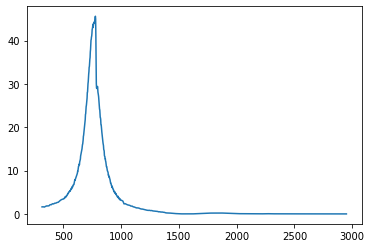

In [5]:
#Upload the data
AbsFF2_list0= []
svalues_list0=[]
FF2err_list0=[]


with open('FF_BABAR2009.txt', 'r') as file:
    lines = file.readlines()
    for line in lines:
        values = line.strip().split('\t')  
        if len(values) >= 2:
            svalues_list0.append(float(values[0]))
            AbsFF2_list0.append(float(values[1]))
            FF2err_list0.append(float(values[2]))
            

#Putting the values into np.arrays that are easier to mathematically use in code             
AbsFF2_0=np.array(AbsFF2_list0)
svalues_0=np.array(svalues_list0)
FF2err_0=np.array(FF2err_list0)

plt.plot(svalues_0,AbsFF2_0) #Checking the form of the data

plt.show()

279 1095.01141546561


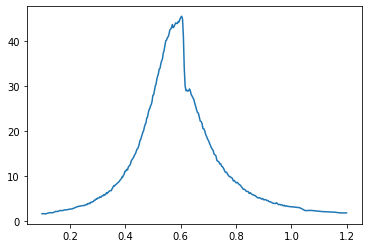

In [6]:
svalues=[]
AbsFF2=[]
FF2err=[]

for i in range(0,len(svalues_0)):
    #if svalues_1[i]<600:
    #    continue     
        
    
    if (svalues_0[i]/1000)**2<=1.2:
        
        svalues.append(svalues_0[i])
        AbsFF2.append(AbsFF2_0[i])
        FF2err.append(FF2err_0[i])

        
        

    if (svalues_0[i]/1000)**2>=1.2:
        print(i,svalues_0[i-1])
        Sstop=i
        break


svalues=(np.array(svalues)/1000)**2
AbsFF2=np.array(AbsFF2)
FF2err=np.array(FF2err)        

plt.plot(svalues,AbsFF2) #Checking the form of the data

plt.show()



##Encrease the importance of φ-mixing from errors

#FF2errTEST=[]
#for i in range(0,len(svalues)):
       
#    if svalues[i]<1.:
#        FF2errTEST.append(FF2err[i])
        
    
#    if 1.<=svalues[i]<=1.08:
#        FF2errTEST.append(FF2err[i])
   
#    if svalues[i]>=1.08:
#        FF2errTEST.append(FF2err[i])

#FF2errTEST=np.array(FF2errTEST)


In [ ]:
#Solve the PV-integral values for the s-values from the SPECIFIC data sets we want
PVresultsData = []


#PVresults1= []

#for i in svalues:
#    result = principal_value_integral(i)
#    PVresults1.append(result)


for i in svalues:
    result, error=integrate.quad(lambda x: integrand(x, i), 4 * Mp**2, np.inf) 
    PVresultsData.append(result)


OmegaData=[]

OmegaData=np.exp( ((svalues*PVresultsData)/ np.pi) + ps_func(svalues)*1j  - np.log(abs((svalues- 4* Mp**2)/(4*Mp**2))  )*ps_func(svalues)/np.pi   )

ReOmegaData= OmegaData.real
ImOmegaData = OmegaData.imag
AbsOmegaData = abs(OmegaData)   
    

In [8]:
def FFfunc(s,a,Ero,Ephi,Momega,Mphi):
    return (1+a*s+((Ero*s)/(Momega**2-s-Momega*Γomegatot*1j))+((Ephi*s)/(Mphi**2-s-Mphi*Γphitot*1j)))*OmegaData



def AbsFF2func(s,a,Ero,Ephi,Momega,Mphi):
    return (  (abs((1+a* s+((Ero* s)/(Momega**2-s-Momega*Γomegatot*1j))+((Ephi*s)/(Mphi**2-s-Mphi*Γphitot*1j))))**2) *  (AbsOmegaData**2)).real



#  Final error-weighted fit

In [9]:
p0 = [0.9, 0.004, 0.3, 0.78, 1.02]
popt, pcov = curve_fit(AbsFF2func, svalues, AbsFF2, p0=p0, sigma=FF2err, absolute_sigma=True)
parameter_errors = np.sqrt(np.diag(pcov))

print(popt)
print(parameter_errors)

[7.20011334e-02 2.04557710e-03 6.57398733e-04 7.81831611e-01
 1.02439340e+00]
[9.96031314e-04 3.55698863e-05 1.70166829e-04 1.04356636e-04
 2.48672706e-04]


In [10]:
pcov

array([[ 9.92078378e-07, -1.74731234e-11, -9.00359606e-08,
        -7.43655263e-10, -6.25215252e-08],
       [-1.74731234e-11,  1.26521681e-09,  3.16928236e-10,
        -2.60157579e-10,  2.09695705e-10],
       [-9.00359606e-08,  3.16928236e-10,  2.89567498e-08,
        -2.03808628e-11,  1.70995595e-08],
       [-7.43655263e-10, -2.60157579e-10, -2.03808628e-11,
         1.08903075e-08, -6.28033506e-12],
       [-6.25215252e-08,  2.09695705e-10,  1.70995595e-08,
        -6.28033506e-12,  6.18381148e-08]])

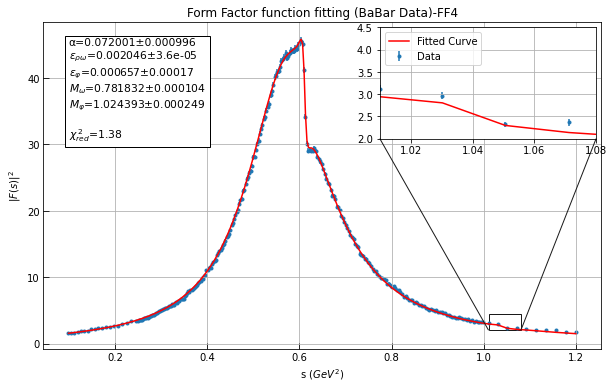

In [11]:
fitted_curve = AbsFF2func(svalues, *popt)


######################

chi2=np.sum(((AbsFF2 - AbsFF2func(svalues, *popt))/FF2err)**2)
Ndof=len(svalues)-len(popt)

chi2red=chi2/Ndof

############################

#%matplotlib notebook
fig, ax = plt.subplots(figsize=(10, 6))

ax.errorbar(svalues, AbsFF2, yerr=FF2err, fmt='.', label='Data',zorder=1) 
ax.plot(svalues, fitted_curve, label='Fitted Curve', color='red',zorder=2)    # Fitted curve

ax.tick_params(axis='both', direction='in', length=6, color='k')
ax.set_xlabel('s $(GeV^{\,2})$')
ax.set_ylabel('$| F(s) |^{\,2}$')
ax.set_title('Form Factor function fitting (BaBar Data)-FF4')
ax.text(0.1, 31, 'α='+str(round(popt[0],6))+'±'+str(round(parameter_errors[0],6))+'\n$ε_{ρω}$='+str(round(popt[1],6))+'±'+str(round(parameter_errors[1],6))+'\n$ε_φ$='+str(round(popt[2],6))+'±'+str(round(parameter_errors[2],6))+'\n$M_ω$='+str(round(popt[3],6))+'±'+str(round(parameter_errors[3],6))+'\n$M_φ$='+str(round(popt[4],6))+'±'+str(round(parameter_errors[4],6))+'\n\n$χ_{red}^{\,2}$='+str(round(chi2red,2)), fontsize = 10.7,bbox = dict(facecolor = 'white', alpha = 1))
ax.grid(True)

# Define the coordinates of the inset area
x1, x2, y1, y2 = 1.01, 1.08 ,2 , 4.5
# Create an inset axes
axins = zoomed_inset_axes(ax, zoom=6.7, loc='upper right')
axins.errorbar(svalues, AbsFF2, yerr=FF2err,fmt='.', label='Data',zorder=1)
axins.plot(svalues, fitted_curve, label='Fitted Curve', color='red',zorder=2)    # Fitted curve
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
mark_inset(ax, axins, loc1=4, loc2=3, fc="none", ec="0.1")

plt.legend(loc='upper left')
plt.grid(True)

#plt.savefig('BaBar-FF4(original_fit).png',bbox_inches ="tight",pad_inches = 0.1,transparent = False,facecolor ="w",edgecolor ='w',dpi=150)

plt.show()

## Calculation of α_μ

In [ ]:
#Redefine the Omnes function and the Form Factor function
@np.vectorize
def OmegaFunc0(s):
    IntResult,err=integrate.quad(lambda x: integrand(x, s), (4 * Mp**2), np.inf)  
    return np.exp( s*(IntResult)/np.pi  + ps_func(s)*1j  - np.log(abs((s- 4* Mp**2)/(4*Mp**2)))*ps_func(s)/np.pi   )
 
svaluesTest=np.linspace(0.07,1.44,1500)
OmegaFunc= interp1d(svaluesTest, OmegaFunc0(svaluesTest))
    

In [13]:
Mm=0.1056583755
alpha=7.2973525693*1e-3

Factor=(alpha**2)/(12* np.pi**2)


def Bp(s):
    return np.sqrt(1- (4* Mp**2)/s)

def sigma_m(s):
    return np.sqrt(1- (4* Mm**2)/s)

def X(s):
    return (1-sigma_m(s))/(1+sigma_m(s))

def K(s):
    return ( ((2-(X(s))**2)*((X(s))**2))/2  + (1+(X(s))**2)*((1+X(s))**2)*(np.log(1+X(s))-X(s)+(((X(s))**2)/2))/(X(s)**2)  + ((1+X(s))*np.log(X(s))*((X(s))**2))/(1-X(s))   )
 

  
@np.vectorize
def Fp2(s):
    return ( (abs((1+popt[0]*s+((popt[1]*s)/(popt[3]**2-s-popt[3]*Γomegatot*1j))+((popt[2]*s)/(popt[4]**2-s-popt[4]*Γphitot*1j))))**2) * (abs(OmegaFunc(s))**2)).real



def integrand2(s):
    return (Factor* K(s)*Fp2(s)* Bp(s)**3)/(s)


In [14]:
AMresult, AMerr=integrate.quad_vec(lambda x: integrand2(x), (4* Mp**2), 1) 

print('α_μ=',AMresult,'(for (4* Mp**2), 1 )')

α_μ= 5.0551698610596715e-08 (for (4* Mp**2), 1 )


In [15]:
AMresultTRY, AMerrTRY=integrate.quad_vec(lambda x: integrand2(x), 0.6**2,0.88**2) 
print('α_μ=',AMresultTRY,AMerrTRY, '(0.6-0.88)')


α_μ= 3.720556440407797e-08 4.636152777585866e-17 (0.6-0.88)


In [16]:
AMresultNEW, AMerrNEW=integrate.quad_vec(lambda x: integrand2(x),0.327**2, 1.2**2) 

print('α_μ=',AMresultNEW,'(for 0.327**2, 1.2**2 )')

α_μ= 5.092684482725697e-08 (for 0.327**2, 1.2**2 )


## Method 1: α_μ  Error

In [17]:
def integrand_I(s):
    return (Factor*(abs(OmegaFunc(s))**2) *K(s)* Bp(s)**3)/(s)


def DERa(s):
    a=popt[0]
    Ero=popt[1]
    Ephi=popt[2]
    Momega=popt[3]
    Mphi=popt[4]
    return 2*s + 2*(s**2)*( a + (Ero*(-s+Momega**2))/(((-s+Momega**2)**2)+ (Momega*Γomegatot)**2) + (Ephi*(-s+Mphi**2))/(((-s+Mphi**2)**2)+ (Mphi*Γphitot)**2)         )

def DERero(s):
    a=popt[0]
    Ero=popt[1]
    Ephi=popt[2]
    Momega=popt[3]
    Mphi=popt[4]
    return (s + (s**2)*(a + (Ero)/(-s-Momega*Γomegatot*1j+Momega**2) + (Ephi)/(-s-Mphi*Γphitot*1j+Mphi**2) ))/(-s+Momega*Γomegatot*1j+ Momega**2)  +  (s + (s**2)*(a + (Ero)/(-s+Momega*Γomegatot*1j+Momega**2) + (Ephi)/(-s+Mphi*Γphitot*1j+Mphi**2) ))/(-s-Momega*Γomegatot*1j+ Momega**2)


def DERephi(s):
    a=popt[0]
    Ero=popt[1]
    Ephi=popt[2]
    Momega=popt[3]
    Mphi=popt[4]
    return (s + (s**2)*(a + (Ero)/(-s-Momega*Γomegatot*1j+Momega**2) + (Ephi)/(-s-Mphi*Γphitot*1j+Mphi**2) ))/(-s+Mphi*Γphitot*1j+ Mphi**2)  +  (s + (s**2)*(a + (Ero)/(-s+Momega*Γomegatot*1j+Momega**2) + (Ephi)/(-s+Mphi*Γphitot*1j+Mphi**2) ))/(-s-Mphi*Γphitot*1j+ Mphi**2)


def DERmomega(s):
    a=popt[0]
    Ero=popt[1]
    Ephi=popt[2]
    Momega=popt[3]
    Mphi=popt[4]
    return (-Ero*s)*( ((2*Momega+Γomegatot*1j)*(1+ s*(a + (Ero)/(-s-Momega*Γomegatot*1j+Momega**2) + (Ephi)/(-s-Mphi*Γphitot*1j+Mphi**2))))/((-s+Momega*Γomegatot*1j+Momega**2)**2)   +   ((2*Momega-Γomegatot*1j)*(1+ s*(a + (Ero)/(-s+Momega*Γomegatot*1j+Momega**2) + (Ephi)/(-s+Mphi*Γphitot*1j+Mphi**2))))/((-s-Momega*Γomegatot*1j+Momega**2)**2)    )



def DERmphi(s):
    a=popt[0]
    Ero=popt[1]
    Ephi=popt[2]
    Momega=popt[3]
    Mphi=popt[4]
    return (-Ephi*s)*( ((2*Mphi+Γphitot*1j)*(1+ s*(a + (Ero)/(-s-Momega*Γomegatot*1j+Momega**2) + (Ephi)/(-s-Mphi*Γphitot*1j+Mphi**2))))/((-s+Mphi*Γphitot*1j+Mphi**2)**2)   +   ((2*Mphi-Γphitot*1j)*(1+ s*(a + (Ero)/(-s+Momega*Γomegatot*1j+Momega**2) + (Ephi)/(-s+Mphi*Γphitot*1j+Mphi**2))))/((-s-Mphi*Γphitot*1j+Mphi**2)**2)       )





In [18]:
AM0,AM0err=integrate.quad_vec(lambda x: DERa(x)*integrand_I(x), (4* Mp**2), 1) 

AM1,AM1err=integrate.quad_vec(lambda x: DERero(x)*integrand_I(x), (4* Mp**2), 1)

AM2,AM2err=integrate.quad_vec(lambda x: DERephi(x)*integrand_I(x), (4* Mp**2), 1) 

AM3,AM3err=integrate.quad_vec(lambda x: DERmomega(x)*integrand_I(x), (4* Mp**2), 1) 

AM4,AM4err=integrate.quad_vec(lambda x: DERmphi(x)*integrand_I(x), (4* Mp**2), 1)


In [19]:
AM_error= np.sqrt( (AM0*parameter_errors[0])**2   +(AM1*parameter_errors[1])**2  +(AM2*parameter_errors[2])**2 +(AM3*parameter_errors[3])**2 +(AM4*parameter_errors[4])**2     )

print('α_μ=', AMresult, '(4*Mp^2-1)\nα_μ(err)=±',AM_error.real)


AM_errorCOR= np.sqrt( (AM0*parameter_errors[0])**2   +(AM1*parameter_errors[1])**2  +(AM2*parameter_errors[2])**2 +(AM3*parameter_errors[3])**2 +(AM4*parameter_errors[4])**2 + 2*AM0*AM1*pcov[0][1] + 2*AM0*AM2*pcov[0][2] + 2*AM0*AM3*pcov[0][3] + 2*AM0*AM4*pcov[0][4]  + 2*AM1*AM2*pcov[1][2] + 2*AM1*AM3*pcov[1][3] + 2*AM1*AM4*pcov[1][4] +2*AM2*AM3*pcov[2][3] +2*AM2*AM4*pcov[2][4] + 2*AM3*AM4*pcov[3][4]     )
print(AM_errorCOR)

α_μ= 5.0551698610596715e-08 (4*Mp^2-1)
α_μ(err)=± 5.193146193959021e-11
(4.183145080787006e-11+0j)


In [20]:
##0.6**2,0.88**2

AMb0,AMb0err=integrate.quad_vec(lambda x: DERa(x)*integrand_I(x), 0.6**2,0.88**2) 

AMb1,AMb1err=integrate.quad_vec(lambda x: DERero(x)*integrand_I(x), 0.6**2,0.88**2)

AMb2,AMb2err=integrate.quad_vec(lambda x: DERephi(x)*integrand_I(x), 0.6**2,0.88**2) 

AMb3,AMb3err=integrate.quad_vec(lambda x: DERmomega(x)*integrand_I(x), 0.6**2,0.88**2) 

AMb4,AMb4err=integrate.quad_vec(lambda x: DERmphi(x)*integrand_I(x), 0.6**2,0.88**2)

In [21]:
AMb_error= np.sqrt( (AMb0*parameter_errors[0])**2   +(AMb1*parameter_errors[1])**2  +(AMb2*parameter_errors[2])**2 +(AMb3*parameter_errors[3])**2 +(AMb4*parameter_errors[4])**2     )


print('α_μ=', AMresultTRY, '(4*Mp^2-1)\nα_μ(err)=±',AMb_error.real)


AMb_errorCOR= np.sqrt( (AMb0*parameter_errors[0])**2   +(AMb1*parameter_errors[1])**2  +(AMb2*parameter_errors[2])**2 +(AMb3*parameter_errors[3])**2 +(AMb4*parameter_errors[4])**2 + 2*AMb0*AMb1*pcov[0][1] + 2*AMb0*AMb2*pcov[0][2] + 2*AMb0*AMb3*pcov[0][3] + 2*AMb0*AMb4*pcov[0][4]  + 2*AMb1*AMb2*pcov[1][2] + 2*AMb1*AMb3*pcov[1][3] + 2*AMb1*AMb4*pcov[1][4] +2*AMb2*AMb3*pcov[2][3] +2*AMb2*AMb4*pcov[2][4] + 2*AMb3*AMb4*pcov[3][4]     )
print(AMb_errorCOR)

α_μ= 3.720556440407797e-08 (4*Mp^2-1)
α_μ(err)=± 4.210526799053631e-11
(3.469710982956002e-11+0j)


In [22]:
#0.327**2, 1.2**2

AMnew0,AMnew0err=integrate.quad_vec(lambda x: DERa(x)*integrand_I(x), 0.327**2, 1.2**2) 

AMnew1,AMnew1err=integrate.quad_vec(lambda x: DERero(x)*integrand_I(x), 0.327**2, 1.2**2)

AMnew2,AMnew2err=integrate.quad_vec(lambda x: DERephi(x)*integrand_I(x), 0.327**2, 1.2**2) 

AMnew3,AMnew3err=integrate.quad_vec(lambda x: DERmomega(x)*integrand_I(x), 0.327**2, 1.2**2) 

AMnew4,AMbnewerr=integrate.quad_vec(lambda x: DERmphi(x)*integrand_I(x), 0.327**2, 1.2**2)

In [23]:
AMnew_error= np.sqrt( (AMnew0*parameter_errors[0])**2   +(AMnew1*parameter_errors[1])**2  +(AMnew2*parameter_errors[2])**2 +(AMnew3*parameter_errors[3])**2 +(AMnew4*parameter_errors[4])**2     )


print('α_μ=', AMresultNEW, '(0.327-1.2)\nα_μ(err)=±',AMnew_error.real)


AMnew_errorCOR= np.sqrt( (AMnew0*parameter_errors[0])**2   +(AMnew1*parameter_errors[1])**2  +(AMnew2*parameter_errors[2])**2 +(AMnew3*parameter_errors[3])**2 +(AMnew4*parameter_errors[4])**2 + 2*AMnew0*AMnew1*pcov[0][1] + 2*AMnew0*AMnew2*pcov[0][2] + 2*AMnew0*AMnew3*pcov[0][3] + 2*AMnew0*AMnew4*pcov[0][4]  + 2*AMnew1*AMnew2*pcov[1][2] + 2*AMnew1*AMnew3*pcov[1][3] + 2*AMnew1*AMnew4*pcov[1][4] +2*AMnew2*AMnew3*pcov[2][3] +2*AMnew2*AMnew4*pcov[2][4] + 2*AMnew3*AMnew4*pcov[3][4]     )
print(AMnew_errorCOR.real)

α_μ= 5.092684482725697e-08 (0.327-1.2)
α_μ(err)=± 5.312991206251646e-11
4.3147879856692586e-11


# Partial Decay Widths

In [24]:
#Values from PDG
Mp=0.13957
Mo=popt[3]
Mf=popt[4]

errMo=parameter_errors[3]
errMf=parameter_errors[4]

Bo_e=0.6e-6 #in GeV
Bf_e=1.27e-6

errBo_e=0.02e-6
errBf_e=0.04e-6

aem=1/137.036


#### g_γω / g_γφ coupling calculation

In [25]:
g_go= np.sqrt((3*Bo_e)/(4*np.pi*Mo* aem**2))

g_gf= np.sqrt((3*Bf_e)/(4*np.pi*Mf* aem**2))


errg_go=np.sqrt(3/(4*np.pi*aem**2))*np.sqrt((errBo_e**2)/(4*Bo_e*Mo) +  (Bo_e* errMo**2)/(4* Mo**3))
errg_gf=np.sqrt(3/(4*np.pi*aem**2))*np.sqrt((errBf_e**2)/(4*Bf_e* Mf) +  (Bf_e* errMf**2)/(4* Mf**3))


print('g_(γω)=',g_go,' error= ', errg_go,'\n')
print('g_(γφ)=',g_gf,' error= ', errg_gf,'\n')

g_(γω)= 0.05865558641328682  error=  0.0009776009444790663 

g_(γφ)= 0.0745519219012113  error=  0.001174080884745118 



In [26]:
# Calculation of ω->ππ coupling
k1=popt[1]
err_k1=parameter_errors[1]

g_opp=k1/g_go

err_g_opp=np.sqrt( (err_k1/g_go)**2  + (k1* errg_go / (g_go**2))**2   )

print('g_(ωππ)=',g_opp   ,' error=',err_g_opp ,'\n' )



# Calculation of φ->ππ coupling
k2=popt[2]
err_k2=parameter_errors[2]

g_fpp=abs(k2/g_gf)

err_g_fpp=np.sqrt( (err_k2/g_gf)**2  + (k2* errg_gf / (g_gf**2))**2   )

print('g_(φππ)=',g_fpp   ,' error=',err_g_fpp )

g_(ωππ)= 0.034874378186750876  error= 0.000839993712064591 

g_(φππ)= 0.008817998472993058  error= 0.0022867483025178353


In [27]:
# Calculation of ω->ππ coupling
#k1=Ero,  k2=Ephi
k1=popt[1]
err_k1=parameter_errors[1]

g_opp=k1/g_go

err_g_opp=np.sqrt( (err_k1/g_go)**2  + (k1* errg_go / (g_go**2))**2   )

print('g_(ωππ)=',g_opp   ,' error=',err_g_opp ,'\n' )



# Calculation of φ->ππ coupling
k2=popt[2]
err_k2=parameter_errors[2]

g_fpp=k2/g_gf

err_g_fpp=np.sqrt( (err_k2/g_gf)**2  + (k2* errg_gf / (g_gf**2))**2   )

print('g_(φππ)=',g_fpp   ,' error=',err_g_fpp )

g_(ωππ)= 0.034874378186750876  error= 0.000839993712064591 

g_(φππ)= 0.008817998472993058  error= 0.0022867483025178353


#### Γ( ..->ππ) calculation

In [28]:
#For ω->ππ
B_opp=((g_opp**2)* ((Mo**2 - 4* Mp**2)**(3/2)) * abs(OmegaFunc(Mo**2))**2 )/(48*np.pi* Mo**2)

err_B_opp=((err_g_opp) *2*g_opp* ((Mo**2 - 4* Mp**2)**(3/2)) * abs(OmegaFunc(Mo**2))**2    )/(48*np.pi* Mo**2)

print('Γ(ω->ππ)=', B_opp, ' error= ', err_B_opp )
print('Γ(ω->ππ)/Γtot=', B_opp/Γomegatot,' error= ', err_B_opp/Γomegatot )
print( '(Γ(ω->ππ)/Γtot)x(Γ(ω->ee)/Γtot) =', (B_opp/Γomegatot)*(Bo_e/Γomegatot), ' error= ', np.sqrt((B_opp*errBo_e)**2 +(Bo_e*err_B_opp)**2  )/(Γomegatot**2))



Γ(ω->ππ)= 0.00017465842791855382  error=  8.4137403353852e-06
Γ(ω->ππ)/Γtot= 0.02057225299394038  error=  0.0009910177073480804
(Γ(ω->ππ)/Γtot)x(Γ(ω->ee)/Γtot) = 1.4538694695364226e-06  error=  8.516877109443572e-08


In [29]:
#For φ->ππ
B_fpp=((g_fpp**2)* ((Mf**2 - 4* Mp**2)**(3/2)) * abs(OmegaFunc(Mf**2))**2 )/(48*np.pi* Mf**2)

err_B_fpp=((err_g_fpp) *2*g_fpp* ((Mf**2 - 4* Mp**2)**(3/2)) * abs(OmegaFunc(Mf**2))**2    )/(48*np.pi* Mf**2)

print('Γ(φ->ππ)=', B_fpp, ' error= ', err_B_fpp)
print('Γ(φ->ππ)/Γtot=', B_fpp/Γphitot,' error= ', err_B_fpp/Γphitot )
print( '(Γ(φ->ππ)/Γtot)x(Γ(φ->ee)/Γtot) =', (B_fpp/Γphitot)*(Bf_e/Γphitot), ' error= ', np.sqrt((B_fpp*errBf_e)**2 +(Bf_e*err_B_fpp)**2  )/(Γphitot**2))

Γ(φ->ππ)= 1.0061004690359014e-06  error=  5.218187657384178e-07
Γ(φ->ππ)/Γtot= 0.00023678523629934133  error=  0.0001228097824755043
(Γ(φ->ππ)/Γtot)x(Γ(φ->ee)/Γtot) = 7.077365264772029e-08  error=  3.677470973438948e-08
